# Applying energy-based models to images - MNIST

Here, I apply EBMs to a simple image dataset (MNIST). First, I begin by describing/implementing different goodness-of-fit scores for image datasets - namely, the inception distance and Frechet inception distance.

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sgld_sampler import sgld_sample
from EBM import EBM
from scores import inception_score, frechet_inception_distance

## Metrics

In order to train the EBMs, I cannot just simply look at the energy function anymore, as there are too
many dimensions. Therefore, I will need to rely on metrics that measure the goodness-of-fit and monitor
those over the iterations. Two suitable and often-used metrics are the inception score (IS)
and Fréchet Inception Distance (FID).

### The Inception Score

The inception score (IS) is obtained by training a classifier on the dataset and then calculating the following statistic
on the generated images:

$$
    S_{\mathrm{IS}} = \exp\left(\mathbb{E}_{x \sim p_g} D_{\mathrm{KL}}(p(y | x) || p(y))\right)
$$

Here, $p(y | x)$ is the conditional distribution of the classifier given the generated image $x$ and
$p(y)$ is the marginal distribution, obtained as $p(y) = \int_x p(y | x) p_g(x) \approx \frac{1}{N} \sum_x p(y | x)$.
The inception score attempts to measure both the diversity of generated images and the peakedness of the conditional distribution. Higher values are better.

### Fréchet Inception Distance

The Fréchet Inception Distance (FID) compares the statistics that are used by the classifier (e.g. the learned filters of the CNN, before the last layer) using the Fréchet distance, which is a distance measure defined for curves. Let $\mu_g$ be the mean
of the statistics of a collection of generated images and $\Sigma_g$ be the covariance of these statistics. $\mu_r$ and $\Sigma_r$ are the mean and covariance of the statistics of a collection of real images. Then the FID is defined as:

$$
    S_{\mathrm{FID}} = || \mu_r - \mu_g||^2 + \mathrm{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1 / 2})
$$

This attempts to measure the difference in statistics of generated vs. real images. Lower values are better.

Implementations of both follow:

### Inception score

In [2]:
def inception_score(p_yx):
    p_y = np.mean(p_yx, axis=0)
    d_kl = np.sum(p_yx * (np.log(p_yx) - np.log(p_y + 1e-6)), axis=1)
    return np.exp(np.mean(d_kl))

### Fréchet Inception Distance

In [3]:
def frechet_inception_distance(statistics_gen, statistics_real):
    mu_g = np.mean(statistics_gen, axis=0)
    cov_g = np.cov(statistics_gen)
    mu_r = np.mean(statistics_real, axis=0)
    cov_r = np.cov(statistics_real)
    diff_mean = np.sum((mu_g - mu_r) ** 2)
    cov_mean_geom = scipy.linalg.sqrtm(cov_r * cov_g)
    if np.iscomplexobj(cov_mean_geom):
        cov_mean_geom = cov_mean_geom.real
    return diff_mean + np.trace(cov_g + cov_r - 2 * cov_mean_geom)

### Classifier for IS/FID

For using IS/FID, we need a classifier. Therefore, we quickly train a classifier for MNIST. We will use
a relatively simple convolutional neural net (CNN).

A very simple CNN architecture is the VGG architecture, which consists of VGG blocks, which are a number
of convolutional layers followed by max pooling.

In [4]:
def vgg_block(layer_in, n_filters, n_conv):
    # Add convolutional layers
    for _ in range(n_conv):
        layer_in = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # Add max pooling layer
    layer_in = keras.layers.MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

#### Defining the model

In [5]:
input_ = keras.layers.Input(shape=(28, 28, 1))
vgg_1 = vgg_block(input_, 128, 3) # 14, 14, 128
vgg_2 = vgg_block(vgg_1, 256, 3) # 7, 7, 256
flatten = keras.layers.Flatten()(vgg_2)
output = keras.layers.Dense(10, activation='softmax')(flatten)
model = keras.Model(inputs=input_, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 256)       590080

#### Loading the training data

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_train_full.shape, y_train_full.shape

((60000, 28, 28), (60000,))

#### Training the classifier

We use a validation set along with early stopping.

In [9]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [10]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, 
                                               restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Epoch 1/5
1719/1719 [==============================] - 32s 10ms/step - loss: 1.1469 - accuracy: 0.6449 - val_loss: 0.0773 - val_accuracy: 0.9788
Epoch 2/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0796 - accuracy: 0.9752 - val_loss: 0.0578 - val_accuracy: 0.9840
Epoch 3/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0520 - accuracy: 0.9834 - val_loss: 0.0524 - val_accuracy: 0.9862
Epoch 4/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.0404 - accuracy: 0.9870 - val_loss: 0.0478 - val_accuracy: 0.9872
Epoch 5/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0312 - accuracy: 0.9903 - val_loss: 0.0384 - val_accuracy: 0.9894


In [11]:
model.save('mnist-classifier-1')

C:\Users\chrku\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2310: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\chrku\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1388: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: mnist-classifier-1\assets


We will use this classifier for our experiments.

In [5]:
mnist_classifier = keras.models.load_model('mnist-classifier-1')

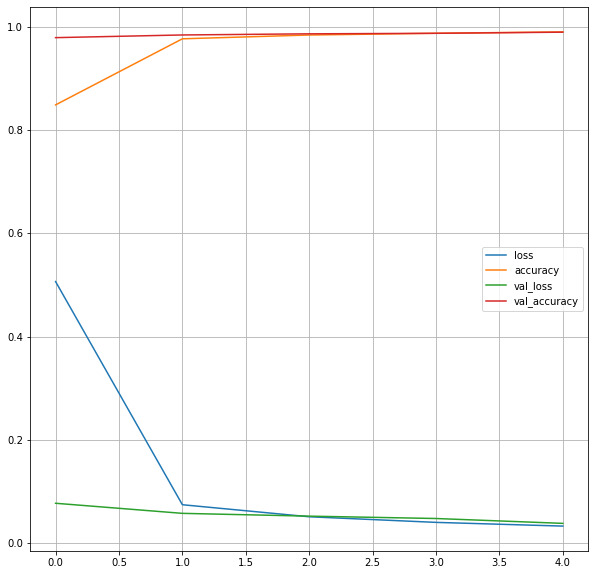

In [13]:
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)

## Evaluation of network performance

To evaluate the network performance, I use metrics, like the IS and FID. The way these are evaluated is that at every batch, they are applied to the generated and real samples. The metrics are then stored in a list. At the end of an epoch, I look at the mean value for each metric of the current epoch and at the last epoch. If the mean value of the current epoch is higher than the mean value of the last epoch, I conclude that the network learned something and save the weights. If not, I conclude that the network has converged or overfit and stop the learning process. For multiple metrics, I perform a majority vote: If the majority agrees that learning occured, I continue. If not, I stop the learning process.

At the end of the learning process, the ```EBM``` object records the trend for all metrics and the best values achieved. Note that I assume that for all metrics, it holds that a higher value means a better value; therefore I negate the FID to fit in that framework. 

In [6]:
def fuse_images(width, height, images, img_width, img_height):
    really_big_image = None
    for i in range(width):
        big_image = None
        for j in range(height):
            cur_image = images[width * i + j].reshape(img_width, img_height)
            if big_image is not None:
                big_image = np.hstack((big_image, cur_image))
            else:
                big_image = cur_image
        if really_big_image is not None:
            really_big_image = np.vstack((really_big_image, big_image))
        else:
            really_big_image = big_image
    return really_big_image

def is_metric_callback(samples_data, samples_energ, it):
    p_yx = mnist_classifier(samples_energ).numpy()
    score = inception_score(p_yx)
    return score

# Need last-layer activations for FID
mnist_statistics = keras.Model(mnist_classifier.input, mnist_classifier.get_layer(name='flatten').output)

def fid_metric_callback(samples_data, samples_energ, it):
    stats_gen = mnist_statistics(samples_energ)
    stats_real = mnist_statistics(samples_data)
    score = frechet_inception_distance(stats_real, stats_gen)
    return -score

### Training a model

In [8]:
def create_model(n_f):
    input_ = keras.layers.Input(shape=(28, 28, 1))
    conv_1 = keras.layers.Conv2D(n_f, kernel_size=3, padding='same', activation='swish')(input_)
    conv_2 = keras.layers.Conv2D(n_f * 2, kernel_size=3, padding='same', activation='swish', strides=2)(conv_1)
    conv_3 = keras.layers.Conv2D(n_f * 4, kernel_size=3, padding='same', activation='swish', strides=2)(conv_2)
    conv_4 = keras.layers.Conv2D(n_f * 8, kernel_size=3, padding='same', activation='swish', strides=2)(conv_3)
    conv_5 = keras.layers.Conv2D(n_f * 16, kernel_size=3, padding='same', activation='swish', strides=2)(conv_4)
    output = keras.layers.Dense(units=1)(conv_5)
    model_ebm = keras.Model(inputs=input_, outputs=output)
    return model_ebm

In [9]:
cur_model = create_model(16)
cur_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 2, 2, 256)         295168    
_________________________________________________________________
dense_2 (Dense)              (None, 2, 2, 1)           257 

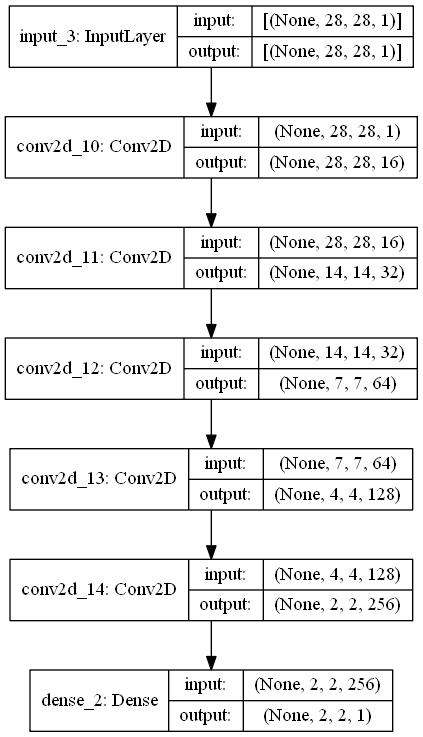

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(cur_model, to_file='energy_model.png', show_shapes=True, show_layer_names=True)

In [9]:
lr = 1e-4
optimizer = keras.optimizers.Adam(lr)

In [10]:
ebm_model = EBM(cur_model, optimizer)
batch_size = 128
step_size = 1
num_epochs = 100

In [ ]:
history = ebm_model.fit(X_train_full, batch_size, num_epochs, 0.0, 1.0, num_steps_markov=tf.constant(100),
                  var=tf.constant(0.005 ** 2), step_size=step_size, callbacks_energy=[],
                  metrics_samples=[("IS", is_metric_callback), ("FID", fid_metric_callback)],
                  clip_thresh=tf.constant(1e6), save_best_weights=True, early_stopping=False, uniform_chance=0.05)

## Sampling from the resulting model

### Replay buffer

In [ ]:
imgs = np.array(ebm_model.replay_buffer[:100])
imgs = np.clip(imgs, 0, 1)
img = fuse_images(10, 10, imgs, 28, 28)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.colorbar()
plt.show()

### SGLD

In [ ]:
batch_size = 100
x_init = tf.random.uniform((batch_size, 28, 28, 1), minval=0, maxval=1)
imgs = sgld_sample(ebm_model.energy, x_init, tf.constant(1500), 1, 0.005 ** 2, clip_thresh=tf.constant(1e6))
imgs = np.clip(imgs, 0, 1)
img = fuse_images(10, 10, imgs, 28, 28)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.colorbar()
plt.show()